In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob, time
import pickle

from utils import get_hog_features

%matplotlib inline

## Load Model

In [2]:
model_pickle = pickle.load( open("model_HSV_all_features.pkl", "rb" ) )
svc = model_pickle["svc"]
X_scaler = model_pickle["scaler"]
orient = model_pickle["orient"]
pix_per_cell = model_pickle["pix_per_cell"]
cell_per_block = model_pickle["cell_per_block"]
spatial_size = model_pickle["spatial_size"]
hist_bins = model_pickle["hist_bins"]

In [3]:
color_reps = {'HSV':cv2.COLOR_BGR2HSV, 
              'LUV': cv2.COLOR_BGR2LUV, 'HLS':cv2.COLOR_BGR2HLS, 
              'YUV': cv2.COLOR_BGR2YUV, 'YCrCb': cv2.COLOR_BGR2YCrCb}

In [4]:
def extract_img_features(img, channel='All', 
                         hog_feat=True, orient=9, pix_per_cell=8, cell_per_block=2, 
                         spatial_feat=True, spatial_size=(16,16), 
                         hist_feat=True, hist_bins=32):
    
    hog_features = np.array([])
    if hog_feat:
        if channel=='All':
            hog_feat1 = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True)
            hog_feat2 = get_hog_features(img[:,:,1], orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True)
            hog_feat3 = get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True)
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
        else:
            hog_features = get_hog_features(img[:,:,channel], orient, 
                                       pix_per_cell, cell_per_block, 
                                       vis=False, feature_vec=True)
            
    hist_features = np.array([])        
    if hist_feat:
        ch1 = np.histogram(img[:,:,0], bins=hist_bins, range=(0, 256))[0]
        ch2 = np.histogram(img[:,:,1], bins=hist_bins, range=(0, 256))[0]
        ch3 = np.histogram(img[:,:,2], bins=hist_bins, range=(0, 256))[0]
        hist_features = np.hstack((ch1, ch2, ch3))
        
    spatial_features = np.array([]) 
    if spatial_feat:
        spatial_features = cv2.resize(img, spatial_size).ravel()
        
    return np.hstack((hog_features, hist_features, spatial_features))

In [6]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



In [8]:
check_imgs = ["camera_cal/calibration"+str(i)+".jpg" for i in range(1,21)]
grid_sizes = [(9,5),(9,6),(9,6),(6,5),(7,6)]+ [(9,6)]*15

def calibration_matrix(imgs, grid_sizes):
    objpoints = []
    imgpoints = []
    for idx, fname in enumerate(imgs):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grid_size = grid_sizes[idx]
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, grid_size, None)

        # If found, add object points, image points
        if ret == True:
            objp = np.zeros((grid_size[0]*grid_size[1],3), np.float32)
            objp[:,:2] = np.mgrid[0:grid_size[0], 0:grid_size[1]].T.reshape(-1,2)

            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return (mtx,dist)

mtx, dist = calibration_matrix(check_imgs,grid_sizes)

mask_vertices = [[300,420],[200,670],[700,600],[1150,670],[1000,420]]
anchor_points = [[592, 453], [695,453],[970, 630],[348, 630]]
tranformed_image_size = (720,720)
PIX2XM = 3.7/330 #lane width is 3.7 meters, 430 pixels in image
PIX2YM = 3.0/60 #dash line is 3 meters long, 60 pixels in image

from LaneFinder import LaneFinder
from moviepy.editor import *

In [37]:
class VehicleLaneFinder(LaneFinder):
    def __init__(self, original_image_size, mask_vertices, anchor_points, tranformed_image_size,
                 cali_mtx, cali_dist, convert_x, convert_y,
                 vehicle_regions,
                 classifier, X_scaler, orient, pix_per_cell, cell_per_block, 
                 spatial_size, hist_bins,
                 window_width=50, window_height=80, margin=100,
                 left_lane_bound=None, right_lane_bound=None,
                 left_lane_pixel_thres = 600, right_lane_pixel_thres=200,
                 smooth_window=5):
        
        super(VehicleLaneFinder, self).__init__( original_image_size, 
                                                mask_vertices, anchor_points, tranformed_image_size,
                                                cali_mtx, cali_dist, convert_x, convert_y,
                                                window_width, window_height, margin,
                                                left_lane_bound, right_lane_bound,
                                                left_lane_pixel_thres, right_lane_pixel_thres,
                                                smooth_window)
        self.vehicle_regions = vehicle_regions
        self.classifier = classifier
        self.X_scaler = X_scaler
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
                
        self.vehicle_heatmap = np.zeros((original_image_size[0],original_image_size[1],10))
        
    def find_car_boxes(self, img):
        windows = []
        for (xstart, xstop, ystart, ystop, scale) in self.vehicle_regions:
            ctrans_tosearch = img[ystart:ystop,xstart:xstop,:]
            if scale != 1:
                imshape = ctrans_tosearch.shape
                ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

            ch1 = ctrans_tosearch[:,:,0]
            ch2 = ctrans_tosearch[:,:,1]
            ch3 = ctrans_tosearch[:,:,2]

            # Define blocks and steps as above
            nxblocks = (ch1.shape[1] // self.pix_per_cell) - self.cell_per_block + 1
            nyblocks = (ch1.shape[0] // self.pix_per_cell) - self.cell_per_block + 1 
            nfeat_per_block = orient*self.cell_per_block**2

            # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
            window = 64
            nblocks_per_window = (window // self.pix_per_cell) - self.cell_per_block + 1
            cells_per_step = 2  # Instead of overlap, define how many cells to step
            nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
            nysteps = (nyblocks - nblocks_per_window) // cells_per_step

            # Compute individual channel HOG features for the entire image
            hog1 = get_hog_features(ch1, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ch2, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)

            for xb in range(nxsteps):
                for yb in range(nysteps):
                    ypos = yb*cells_per_step
                    xpos = xb*cells_per_step
                    # Extract HOG for this patch
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                    xleft = xpos*self.pix_per_cell
                    ytop = ypos*self.pix_per_cell

                    # Extract the image patch
                    subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                    ch1 = np.histogram(subimg[:,:,0], bins=self.hist_bins, range=(0, 256))[0]
                    ch2 = np.histogram(subimg[:,:,1], bins=self.hist_bins, range=(0, 256))[0]
                    ch3 = np.histogram(subimg[:,:,2], bins=self.hist_bins, range=(0, 256))[0]
                    hist_features = np.hstack((ch1, ch2, ch3))

                    # Get color features
                    spatial_features = cv2.resize(subimg, self.spatial_size).ravel()
                    # Scale features and make a prediction
                    test_features = self.X_scaler.transform(np.hstack((hog_features, hist_features, 
                                                                  spatial_features)).reshape(1,-1))    
        #             test_features = X_scaler.transform(hog_features)    
                    test_prediction = self.classifier.predict(test_features)

                    if test_prediction == 1:
                        xbox_left = np.int(xleft*scale)
                        ytop_draw = np.int(ytop*scale)
                        win_draw = np.int(window*scale)
                        windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

        return windows
    
    def channel_decompose(self, img, saturation_white_thresh=(0, 2),
                         saturation_yellow_thresh=(100, 180),
                         hue_thresh=(18, 25), value_thresh=(200, 255),
                         component_limit=6, min_area=1000,
                         ksize=15):

        v_channel = img[:,:,2]
        v_binary = np.zeros_like(v_channel)
        v_binary[(v_channel>=value_thresh[0])&(v_channel<=value_thresh[1])] = 1
        self.thresholds = [50]

        return [v_binary]
    
    def pipeline(self, img):
        # reset information for the current frame
        self.lane.reset_canvas()
        self.texts = []
        self.window_centroids = [[],[]]
        
        # undistort and apply perspective transformation to get birdview
        undistort_img = cv2.undistort(img, self.calibration_matrix, self.calibration_dist,
                                   None, self.calibration_matrix)
        warped_img = cv2.cvtColor(undistort_img, cv2.COLOR_RGB2HSV)
        
        # detect vehicle
        windows = self.find_car_boxes(warped_img)
        
        warped_img = cv2.warpPerspective(warped_img, self.M,
                                       (self.height,self.width),
                                       flags=cv2.INTER_LINEAR)

        # apply different filters to create candidate channels
        channels = self.channel_decompose(warped_img)
#         print(self.mask.shape,)
        self.channels = [im*self.mask for im in channels] #ignore outside of masked region
        L = len(channels)

        text = ''
        # If lane-line is detected from the previous frame,
        # then use tube_lane_finder
        if self.lane.left_detected and self.lane.left_fitx is not None:
            channel_left_idx = 0
            while channel_left_idx<L and (not self.tube_lane_finder(self.channels[channel_left_idx],0)):
                channel_left_idx += 1
            text += 'L channel:' + str(channel_left_idx)+' pix:'+ str(self.lane.left_x.size) + ', '
        else: # otherwise search from scratch
            text += 'L init '
            self.init_lane_finder(side=0)

        # same process applied to right lane-line
        if self.lane.right_detected and self.lane.right_fitx is not None:
            channel_right_idx = 0
            while channel_right_idx<L and (not self.tube_lane_finder(self.channels[channel_right_idx],1)):
                channel_right_idx += 1
            text += 'R channel:' + str(channel_right_idx)+' pix:'+ str(self.lane.right_x.size)
        else:
            text += 'R init '
            self.init_lane_finder(side=1)

        if len(text)>0: self.texts.append(text)

        if (self.lane.left_x.size>0) and (self.lane.right_x.size>0):
            # compute curvature and center offset
            (curvature, center_offset) = self.lane.analyze()
            self.texts.append("Curvature: "+"{:04.1f}".format(curvature) + 'm')
            self.texts.append("Distance from Center: "+"{:04.3f}".format(center_offset)+ 'm')

        overlay = cv2.warpPerspective(self.draw_lane(), self.M_inv,
                                      (self.original_image_size[1],self.original_image_size[0]),
                                      flags=cv2.INTER_LINEAR)
    
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat,windows)
        self.vehicle_heatmap = np.roll(self.vehicle_heatmap,shift=(0,0,-1))
        self.vehicle_heatmap[:,:,-1] = heat
        
#         tmp = np.clip(np.sum(self.vehicle_heatmap,axis=2), 0, 255)
#         return np.dstack((tmp,tmp,tmp))

        # Apply threshold to help remove false positives
        heat = apply_threshold(np.sum(self.vehicle_heatmap,axis=2),6)

        # Visualize the heatmap when displaying
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        overlay = draw_labeled_bboxes(overlay, labels)
        
        return self.draw_result(cv2.addWeighted(undistort_img, 1, overlay, 1, 0.0))

In [ ]:
lane_finder = VehicleLaneFinder((720,1280), mask_vertices, anchor_points, tranformed_image_size, 
                                 mtx, dist, PIX2XM, PIX2YM, 
                                 vehicle_regions = [(50, 1280, 400, 656, 1.5),(200, 1000, 400, 464, 0.5)],
                                 classifier=svc, X_scaler=X_scaler, orient=orient, 
                                 pix_per_cell=pix_per_cell, 
                                 cell_per_block=cell_per_block, 
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 window_width=50, window_height=80, margin=100)

input_vid = 'project_video.mp4'
output = 'output_images/'+input_vid[:-4]+"_output_all.mp4"
clip2 = VideoFileClip(input_vid)
challenge_clip = clip2.fl_image(lane_finder.pipeline)
%time challenge_clip.write_videofile(output, audio=False)

In [40]:
lane_finder = VehicleLaneFinder((720,1280), mask_vertices, anchor_points, tranformed_image_size, 
                                 mtx, dist, PIX2XM, PIX2YM, 
                                 vehicle_regions = [(50, 1280, 400, 656, 1.5)],
                                 classifier=svc, X_scaler=X_scaler, orient=orient, 
                                 pix_per_cell=pix_per_cell, 
                                 cell_per_block=cell_per_block, 
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 window_width=50, window_height=80, margin=100)

input_vid = 'project_video.mp4'
output = 'output_images/'+input_vid[:-4]+"_output.mp4"
clip2 = VideoFileClip(input_vid)
challenge_clip = clip2.fl_image(lane_finder.pipeline)
%time challenge_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4



 12%|█▏        | 152/1261 [01:15<09:25,  1.96it/s]


 24%|██▍       | 303/1261 [02:29<07:29,  2.13it/s]


 36%|███▌      | 454/1261 [03:41<06:08,  2.19it/s]


 48%|████▊     | 605/1261 [04:52<05:16,  2.07it/s]


 49%|████▉     | 619/1261 [04:59<05:02,  2.13it/s]

Lane intersects



 61%|██████    | 770/1261 [06:09<04:05,  2.00it/s]


 73%|███████▎  | 921/1261 [07:22<02:48,  2.02it/s]


 85%|████████▍ | 1071/1261 [08:35<01:28,  2.16it/s]


 97%|█████████▋| 1219/1261 [09:49<00:21,  1.94it/s]


100%|█████████▉| 1260/1261 [10:09<00:00,  2.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 9min 53s, sys: 1min 19s, total: 11min 12s
Wall time: 10min 9s


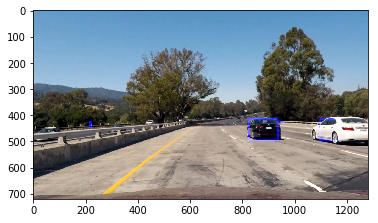

In [16]:
test_img = cv2.imread("test_images/test1.jpg")

lane_finder = VehicleLaneFinder((720,1280), mask_vertices, anchor_points, tranformed_image_size, 
                                 mtx, dist, PIX2XM, PIX2YM, 
                                 vehicle_regions = [(400, 656, 1.5),(400, 464, 0.5)],
                                 classifier=svc, X_scaler=X_scaler, orient=orient, 
                                 pix_per_cell=pix_per_cell, 
                                 cell_per_block=cell_per_block, 
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 window_width=50, window_height=80, margin=100)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
res = lane_finder.pipeline(test_img)
plt.imshow(res)
mpimg.imsave("test6_final.png", res)